In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
%matplotlib inline

In [14]:
from sklearn import datasets
iris = datasets.load_iris()

df=pd.DataFrame(iris.data)
df['Species']=iris.target

df.columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
df.dropna(how="all", inplace=True)

In [15]:
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Text(0.5, 1.0, 'scatter')

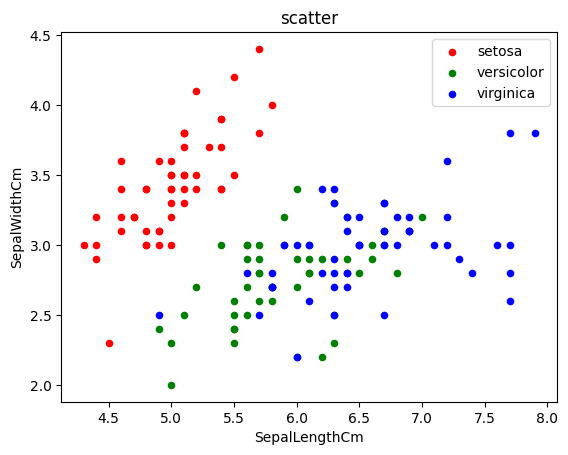

In [24]:
ax = df[df.Species==0].plot.scatter(x='SepalLengthCm', y='SepalWidthCm', color='red', label='setosa')
df[df.Species==1].plot.scatter(x='SepalLengthCm', y='SepalWidthCm', color='green', label='versicolor', ax=ax)
df[df.Species==2].plot.scatter(x='SepalLengthCm', y='SepalWidthCm', color='blue', label='virginica', ax=ax)
ax.set_title("scatter")

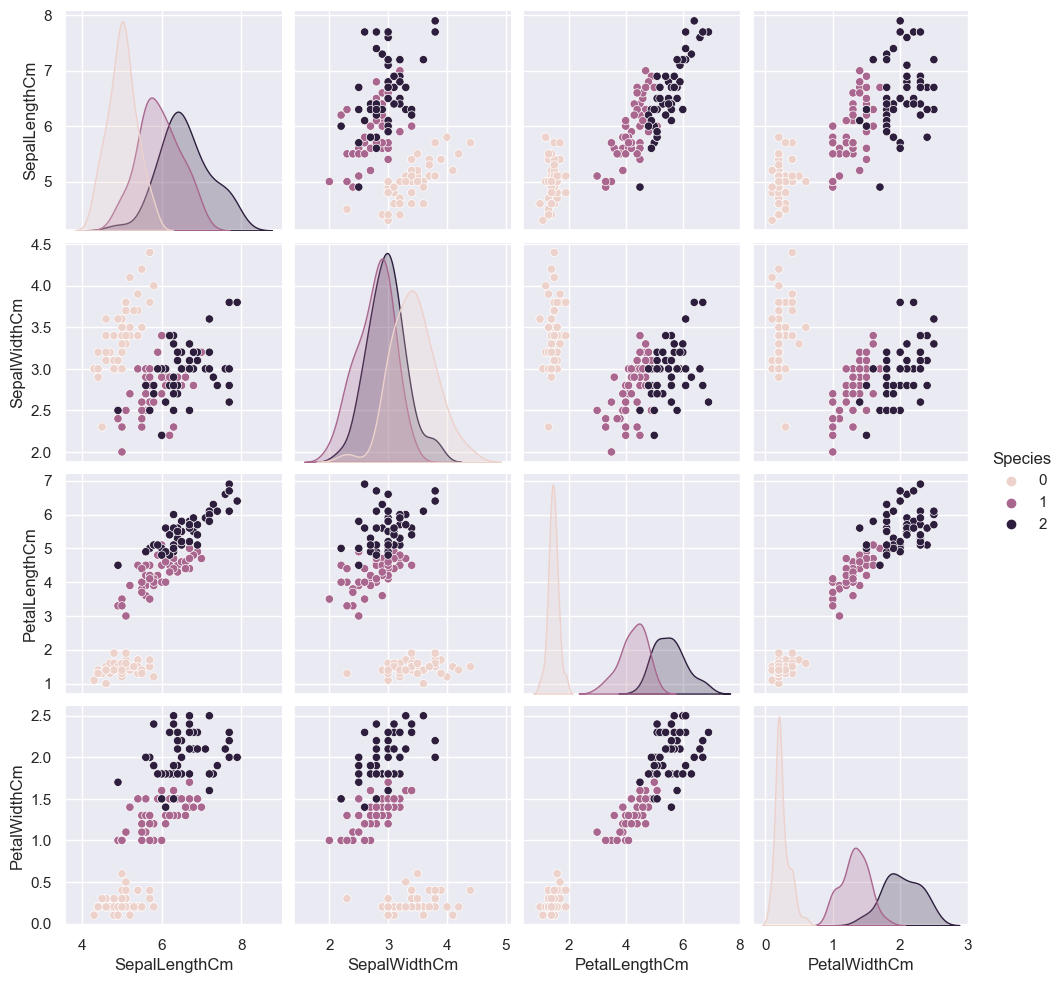

In [28]:
sns.set()
sns.pairplot(df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']],
             hue="Species", diag_kind="kde")

In [29]:
x = iris.data
y = iris.target

# Normalize

# One-hot encode labels
num_labels = 3
examples = y.shape[0]
y_new = one_hot(y.astype('int32'), num_labels)

# Split, reshape, shuffle
train_size = 120
test_size = x.shape[0] - train_size
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y_new[:train_size], y_new[train_size:]
shuffle_index = np.random.permutation(train_size)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

(30, 4)

In [26]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

In [115]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        self.loss = []
        self.acc = []
        self.loss_test = []
        
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        self.params = self.initialize()
        self.cache = {}
        
    def relu(self, x, derivative=False):
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }
        return params
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    
    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.
        '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
                
    def optimize(self, l_rate=0.1, beta=.9):
        '''
            SGD:
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))
    
    def plot_loss(self):
        return self.loss
    
    def get_acc_loss_test(self):
        return self.acc, self.loss_test

    def train(self, x_train, y_train, x_test, y_test, epochs=100, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        self.epochs = epochs
        if batch_size != 1:
            self.batch_size = batch_size
        else:
            self.batch_size = 2
            
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        
        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        
        for i in range(self.epochs):
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                output = self.feed_forward(x)
                grad = self.back_propagate(y, output)
                self.optimize(l_rate=l_rate, beta=beta)

            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            self.loss.append(train_loss)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            self.acc.append(test_acc)
            self.loss_test.append(test_loss)
            
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

In [116]:
import time
dnn = DeepNeuralNetwork(sizes=[4, 4, 3], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, epochs=100, batch_size=120, optimizer='momentum', l_rate=4, beta=.9)

Epoch 1: 0.00s, train acc=0.81, train loss=1.03, test acc=0.00, test loss=1.70
Epoch 2: 0.01s, train acc=0.42, train loss=1.01, test acc=0.00, test loss=1.93
Epoch 3: 0.01s, train acc=0.42, train loss=0.99, test acc=0.00, test loss=2.11
Epoch 4: 0.01s, train acc=0.44, train loss=0.96, test acc=0.00, test loss=2.11
Epoch 5: 0.01s, train acc=0.83, train loss=0.91, test acc=0.00, test loss=1.99
Epoch 6: 0.01s, train acc=0.83, train loss=0.86, test acc=0.00, test loss=1.80
Epoch 7: 0.01s, train acc=0.82, train loss=0.82, test acc=0.00, test loss=1.62
Epoch 8: 0.01s, train acc=0.83, train loss=0.74, test acc=0.00, test loss=1.44
Epoch 9: 0.01s, train acc=0.83, train loss=0.67, test acc=0.00, test loss=1.35
Epoch 10: 0.01s, train acc=0.83, train loss=0.61, test acc=0.00, test loss=1.35
Epoch 11: 0.01s, train acc=0.83, train loss=0.54, test acc=0.00, test loss=1.39
Epoch 12: 0.01s, train acc=0.83, train loss=0.50, test acc=0.00, test loss=1.44
Epoch 13: 0.01s, train acc=0.83, train loss=0.46,

In [117]:
loss = dnn.plot_loss()

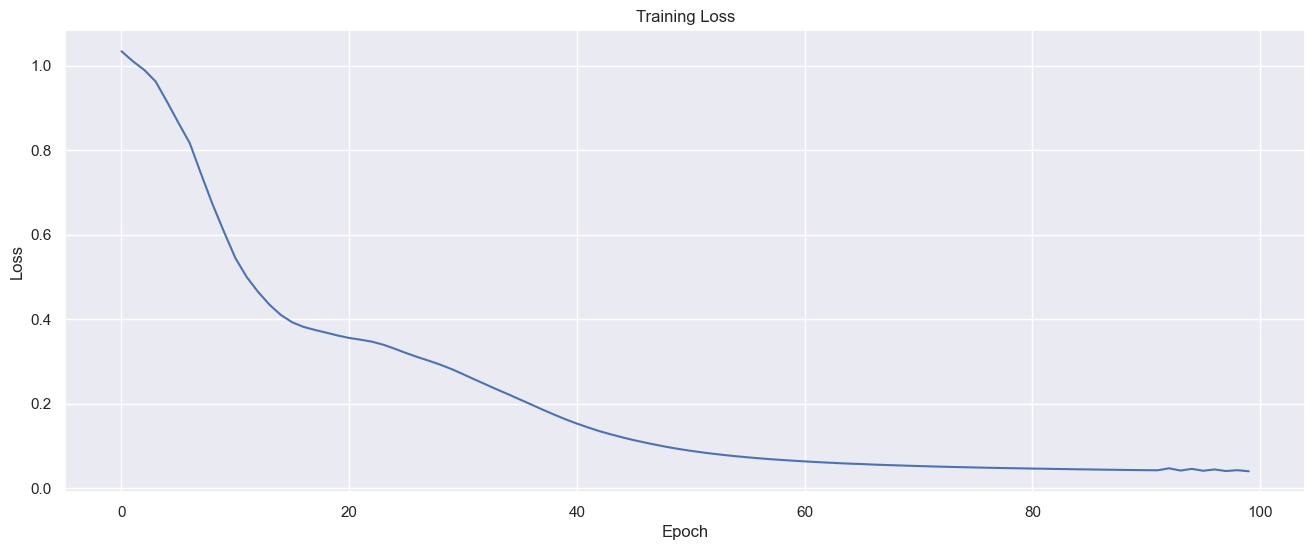

In [118]:
plt.figure(figsize=(16,6))
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [94]:
dnn_bgd = DeepNeuralNetwork(sizes=[4, 4, 3], activation='sigmoid')
dnn_bgd.train(x_train, y_train, x_test, y_test, epochs=100, batch_size=32, optimizer='momentum', l_rate=4, beta=.9)

Epoch 1: 0.00s, train acc=0.42, train loss=1.15, test acc=0.00, test loss=2.80
Epoch 2: 0.00s, train acc=0.83, train loss=0.87, test acc=0.00, test loss=2.38
Epoch 3: 0.01s, train acc=0.83, train loss=0.65, test acc=0.00, test loss=1.18
Epoch 4: 0.01s, train acc=0.83, train loss=0.49, test acc=0.00, test loss=1.68
Epoch 5: 0.01s, train acc=0.83, train loss=0.39, test acc=0.00, test loss=1.52
Epoch 6: 0.01s, train acc=0.83, train loss=0.38, test acc=0.00, test loss=0.91
Epoch 7: 0.01s, train acc=0.83, train loss=0.41, test acc=0.00, test loss=2.06
Epoch 8: 0.01s, train acc=0.83, train loss=0.33, test acc=0.00, test loss=0.99
Epoch 9: 0.01s, train acc=0.83, train loss=0.35, test acc=0.00, test loss=1.22
Epoch 10: 0.01s, train acc=0.85, train loss=0.25, test acc=0.03, test loss=1.01
Epoch 11: 0.01s, train acc=0.98, train loss=0.28, test acc=0.67, test loss=0.69
Epoch 12: 0.02s, train acc=0.97, train loss=0.28, test acc=1.00, test loss=0.58
Epoch 13: 0.02s, train acc=0.62, train loss=0.52,

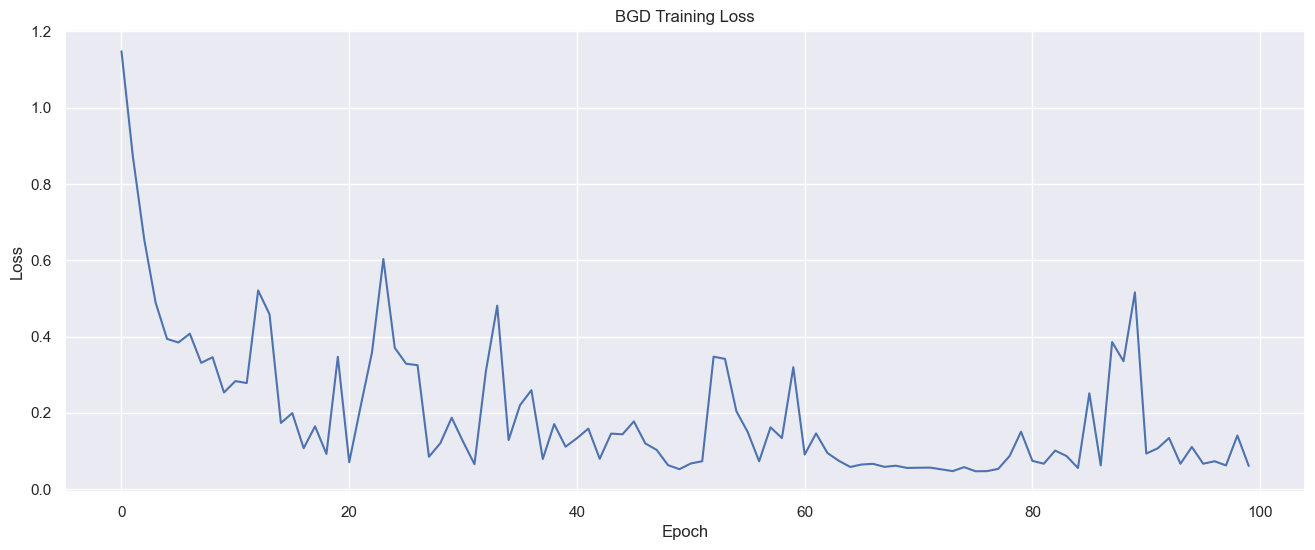

In [95]:
loss_bgd = dnn_bgd.plot_loss()
plt.figure(figsize=(16,6))
plt.plot(loss_bgd)
plt.title('BGD Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [110]:
dnn_sgd = DeepNeuralNetwork(sizes=[4, 4, 3], activation='sigmoid')
dnn_sgd.train(x_train, y_train, x_test, y_test, epochs=100, batch_size=1, optimizer='sgd', l_rate=4, beta=.9)

Epoch 1: 0.01s, train acc=0.42, train loss=2.31, test acc=0.00, test loss=4.40
Epoch 2: 0.02s, train acc=0.42, train loss=2.36, test acc=0.00, test loss=4.88
Epoch 3: 0.02s, train acc=0.42, train loss=2.48, test acc=0.00, test loss=4.93
Epoch 4: 0.02s, train acc=0.42, train loss=2.36, test acc=0.00, test loss=4.41
Epoch 5: 0.03s, train acc=0.42, train loss=2.14, test acc=0.00, test loss=3.87
Epoch 6: 0.03s, train acc=0.42, train loss=2.12, test acc=0.00, test loss=4.08
Epoch 7: 0.03s, train acc=0.17, train loss=3.80, test acc=1.00, test loss=0.02
Epoch 8: 0.03s, train acc=0.42, train loss=2.59, test acc=0.00, test loss=4.28
Epoch 9: 0.04s, train acc=0.42, train loss=2.60, test acc=0.00, test loss=4.98
Epoch 10: 0.04s, train acc=0.42, train loss=2.41, test acc=0.00, test loss=4.44
Epoch 11: 0.04s, train acc=0.42, train loss=2.63, test acc=0.00, test loss=4.25
Epoch 12: 0.05s, train acc=0.17, train loss=3.30, test acc=1.00, test loss=0.04
Epoch 13: 0.05s, train acc=0.17, train loss=3.72,

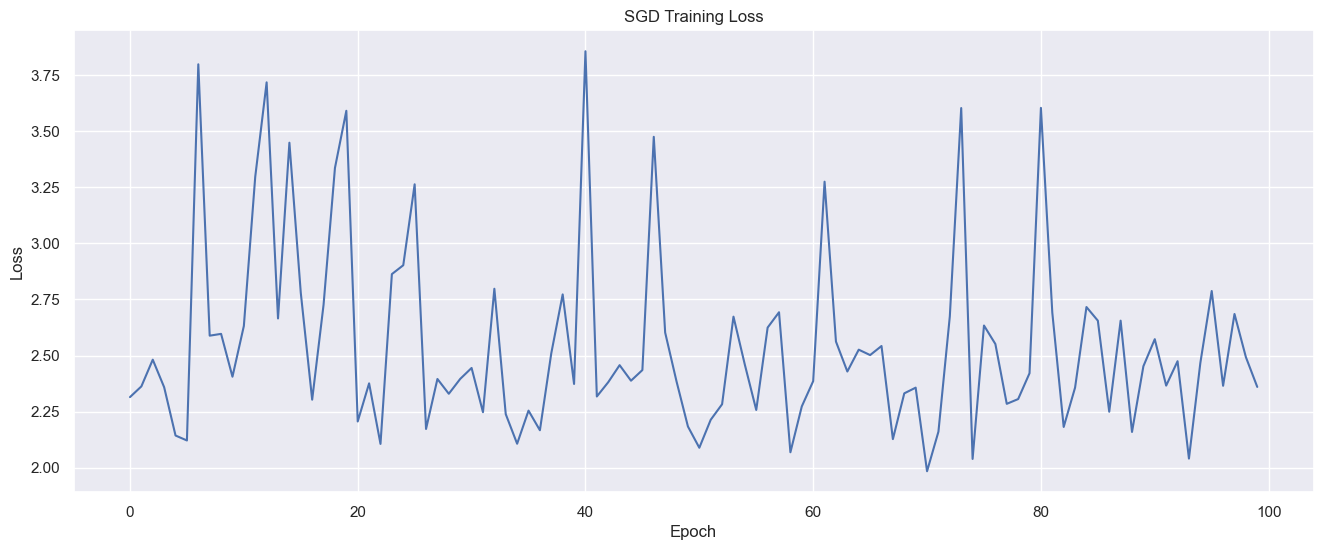

In [111]:
loss_sgd = dnn_sgd.plot_loss()
plt.figure(figsize=(16,6))
plt.plot(loss_sgd)
plt.title('SGD Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [119]:
gd_acc, gd_test_loss = dnn.get_acc_loss_test()

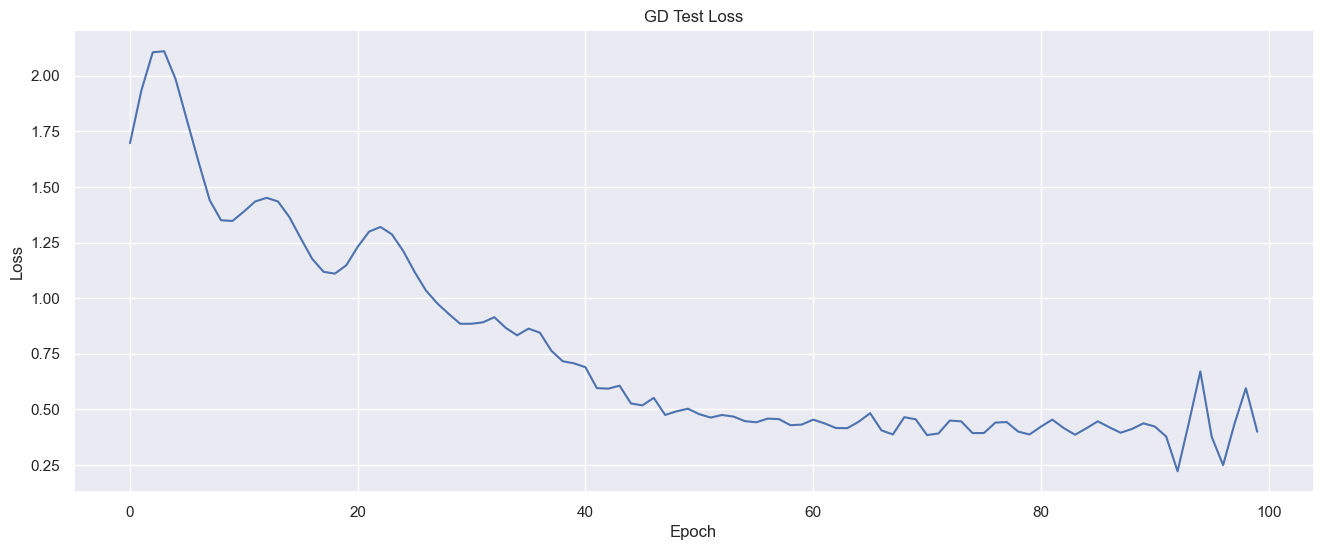

In [120]:
plt.figure(figsize=(16,6))
plt.plot(gd_test_loss)
plt.title('GD Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

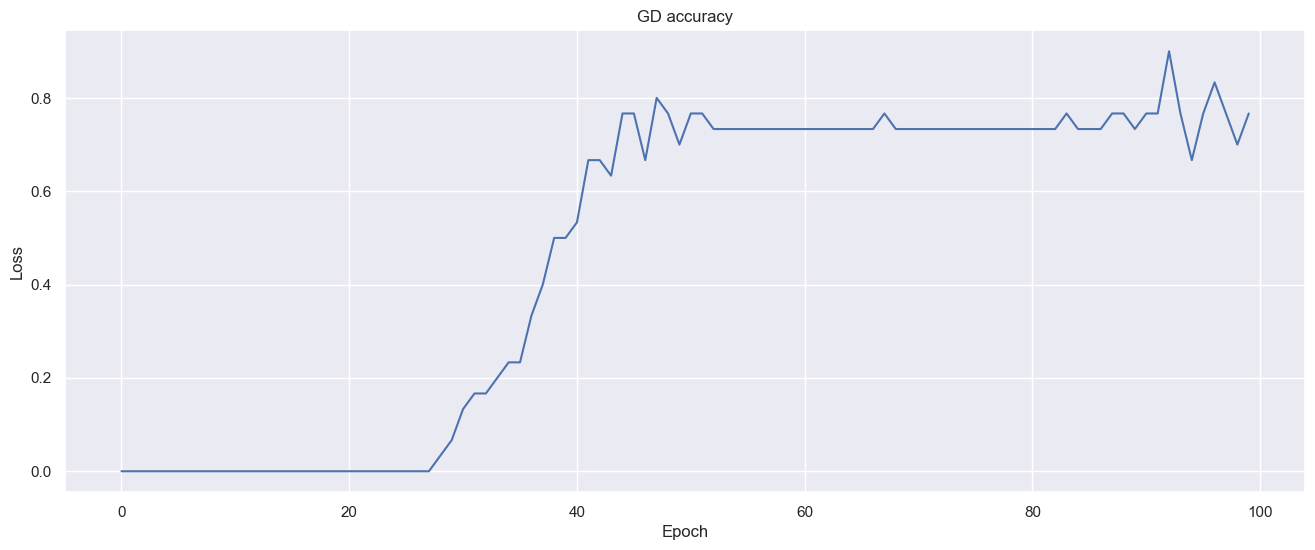

In [122]:
plt.figure(figsize=(16,6))
plt.plot(gd_acc)
plt.title('GD accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Feedforward

we have to multiply the weights by the activations of the previous layer. Then we have to apply the activation function to the outcome.
To get through each layer, we sequentially apply the dot operation, followed by the sigmoid/relu activation function. In the last layer we use the softmax activation function, since we wish to have probabilities of each class, so that we can measure how well our current forward pass performs.

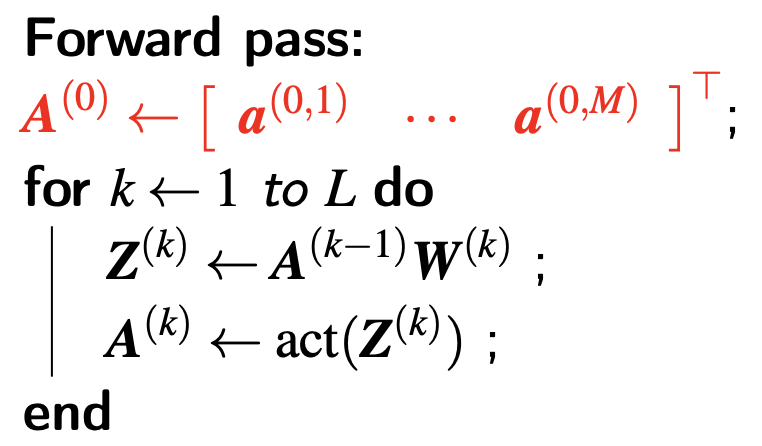

# Backpropagation

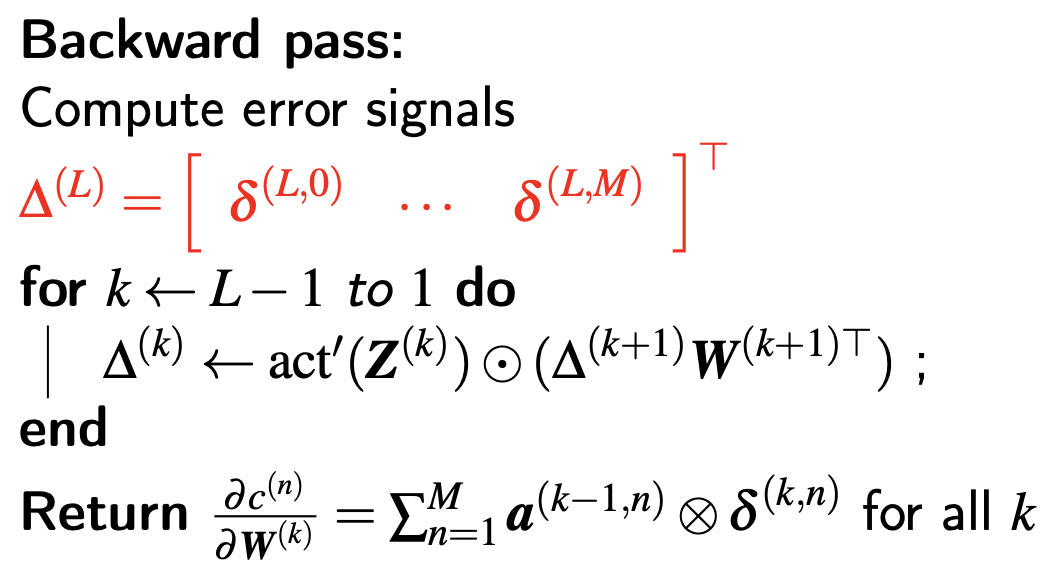

# GD with different starting points

In [131]:
np.random.seed(42)
dnn1 = DeepNeuralNetwork(sizes=[4, 4, 3], activation='sigmoid')
dnn1.train(x_train, y_train, x_test, y_test, epochs=100, batch_size=120, optimizer='momentum', l_rate=4, beta=.9)

np.random.seed(15)
dnn2 = DeepNeuralNetwork(sizes=[4, 4, 3], activation='sigmoid')
dnn2.train(x_train, y_train, x_test, y_test, epochs=100, batch_size=120, optimizer='momentum', l_rate=4, beta=.9)

np.random.seed(1)
dnn3 = DeepNeuralNetwork(sizes=[4, 4, 3], activation='sigmoid')
dnn3.train(x_train, y_train, x_test, y_test, epochs=100, batch_size=120, optimizer='momentum', l_rate=4, beta=.9)

Epoch 1: 0.00s, train acc=0.42, train loss=1.08, test acc=0.00, test loss=1.45
Epoch 2: 0.00s, train acc=0.83, train loss=1.01, test acc=0.00, test loss=1.50
Epoch 3: 0.00s, train acc=0.42, train loss=1.03, test acc=0.00, test loss=1.61
Epoch 4: 0.00s, train acc=0.42, train loss=1.02, test acc=0.00, test loss=1.78
Epoch 5: 0.00s, train acc=0.47, train loss=0.95, test acc=0.00, test loss=2.00
Epoch 6: 0.00s, train acc=0.83, train loss=0.93, test acc=0.00, test loss=2.16
Epoch 7: 0.00s, train acc=0.57, train loss=0.92, test acc=0.00, test loss=2.23
Epoch 8: 0.00s, train acc=0.83, train loss=0.84, test acc=0.00, test loss=2.17
Epoch 9: 0.01s, train acc=0.83, train loss=0.78, test acc=0.00, test loss=2.01
Epoch 10: 0.01s, train acc=0.82, train loss=0.73, test acc=0.00, test loss=1.83
Epoch 11: 0.01s, train acc=0.83, train loss=0.64, test acc=0.00, test loss=1.67
Epoch 12: 0.01s, train acc=0.83, train loss=0.58, test acc=0.00, test loss=1.50
Epoch 13: 0.01s, train acc=0.83, train loss=0.54,

In [132]:
gd1_acc, gd1_test_loss = dnn1.get_acc_loss_test()
gd2_acc, gd2_test_loss = dnn2.get_acc_loss_test()
gd3_acc, gd3_test_loss = dnn3.get_acc_loss_test()

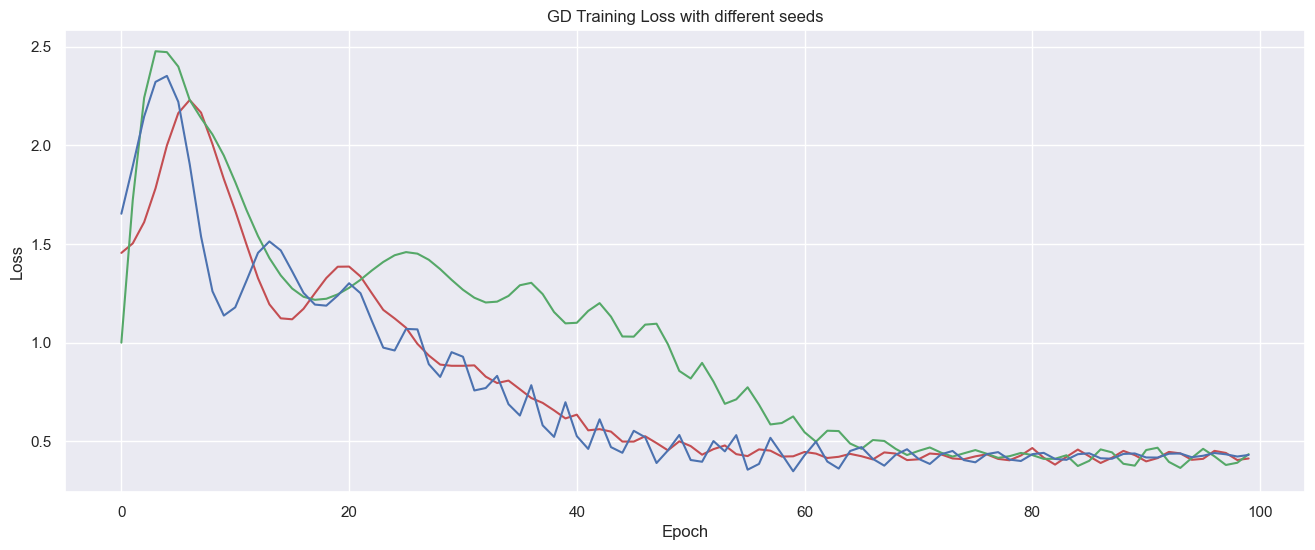

In [133]:
plt.figure(figsize=(16,6))

plt.plot(gd1_test_loss, color = 'r')
plt.plot(gd2_test_loss, color = 'g')
plt.plot(gd3_test_loss, color = 'b')

plt.title('GD Training Loss with different seeds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

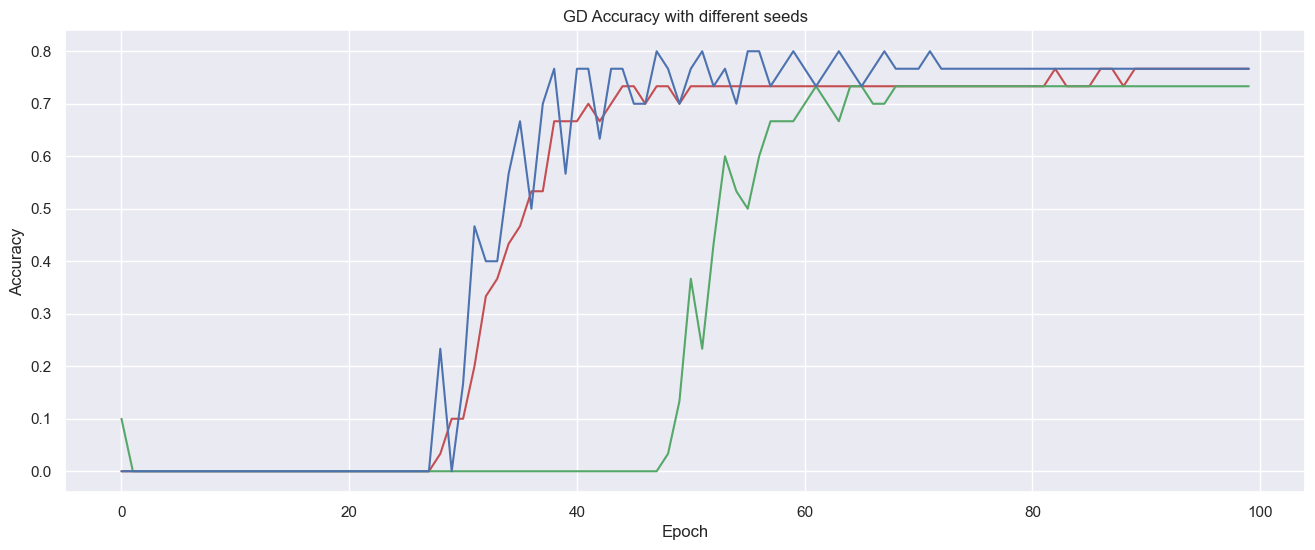

In [134]:
plt.figure(figsize=(16,6))

plt.plot(gd1_acc, color = 'r')
plt.plot(gd2_acc, color = 'g')
plt.plot(gd3_acc, color = 'b')

plt.title('GD Accuracy with different seeds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()